In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import numpy as np
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import pandas as pd

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        
        self.features = nn.Sequential(
          
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
           
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
         
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
       
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )
        
       
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, targets in test_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc, all_preds, all_targets

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def calculate_metrics(true_labels, pred_labels):
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')
    return accuracy, precision, recall, f1


# Function to create performance summary table
def create_performance_summary(models_dict, test_loader, device, class_names):
    results = []
    
    for model_name, model in models_dict.items():
        # Get predictions
        _, _, all_preds, all_targets = evaluate_model(model, test_loader, device)
        
        accuracy, precision, recall, f1 = calculate_metrics(all_targets, all_preds)
        
        # Storing results
        results.append({
            'Model': model_name,
            'Accuracy': f'{accuracy:.4f}',
            'Precision': f'{precision:.4f}',
            'Recall': f'{recall:.4f}',
            'F1-Score': f'{f1:.4f}'
        })
        
        #confusion matrix
        print(f"\nConfusion Matrix for {model_name}")
        plot_confusion_matrix(all_targets, all_preds, class_names)
    
    # summary table
    summary_df = pd.DataFrame(results)
    return summary_df


def train_model(model, train_loader, test_loader, epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    metrics_history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'test_loss': [], 'test_acc': []
    }
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Validation 
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100. * correct / total
        
        # Test 
        test_loss, test_acc, _, _ = evaluate_model(model, test_loader, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Stornig the metrics
        metrics_history['train_loss'].append(train_loss)
        metrics_history['train_acc'].append(train_acc)
        metrics_history['val_loss'].append(val_loss)
        metrics_history['val_acc'].append(val_acc)
        metrics_history['test_loss'].append(test_loss)
        metrics_history['test_acc'].append(test_acc)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
        print('-' * 50)
    
    return metrics_history

def get_limited_data_loaders(train_per_class=500, test_per_class=100, batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    
    # Create indices for each class
    train_idx = []
    test_idx = []
    
    for class_id in range(10):  # CIFAR-10 has 10 classes
        # Get indices for current class
        train_class_idx = np.where(np.array(trainset.targets) == class_id)[0]
        test_class_idx = np.where(np.array(testset.targets) == class_id)[0]
        
        # Randomly select limited number of images per class
        train_selected = np.random.choice(train_class_idx, train_per_class, replace=False)
        test_selected = np.random.choice(test_class_idx, test_per_class, replace=False)
        
        train_idx.extend(train_selected)
        test_idx.extend(test_selected)
    
    # Create subset datasets
    limited_trainset = torch.utils.data.Subset(trainset, train_idx)
    limited_testset = torch.utils.data.Subset(testset, test_idx)
    
 
    trainloader = DataLoader(
        limited_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(
        limited_testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return trainloader, testloader


class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        
        self.features = nn.Sequential(
            # Reduced number of convolutional blocks
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Variant with larger kernel sizes
class VGG11LargeKernel(nn.Module):
    def __init__(self):
        super(VGG11LargeKernel, self).__init__()
        
        self.features = nn.Sequential(
            # Using larger 5x5 kernels in early layers
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Using 3x3 kernels in later layers
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 10)
        )
        
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

using:  cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10:
Train Loss: 2.2190 | Train Acc: 15.66%
Val Loss: 2.0272 | Val Acc: 21.30%
Test Loss: 2.0272 | Test Acc: 21.30%
--------------------------------------------------
Epoch 2/10:
Train Loss: 1.8761 | Train Acc: 25.90%
Val Loss: 1.8597 | Val Acc: 27.50%
Test Loss: 1.8597 | Test Acc: 27.50%
--------------------------------------------------
Epoch 3/10:
Train Loss: 1.7544 | Train Acc: 32.58%
Val Loss: 1.7237 | Val Acc: 35.80%
Test Loss: 1.7237 | Test Acc: 35.80%
--------------------------------------------------
Epoch 4/10:
Train Loss: 1.6765 | Train Acc: 36.68%
Val Loss: 1.6628 | Val Acc: 38.00%
Test Loss: 1.6628 | Test Acc: 38.00%
--------------------------------------------------
Epoch 5/10:
Train Loss: 1.5141 | Train Acc: 41.42%
Val Loss: 1.5558 | Val Acc: 38.90%
Test Loss: 1.5558 | Test Acc: 38.90%
--------------------------------------------------
Epoch 6/10:
Train Loss: 1.4706 | Train Ac

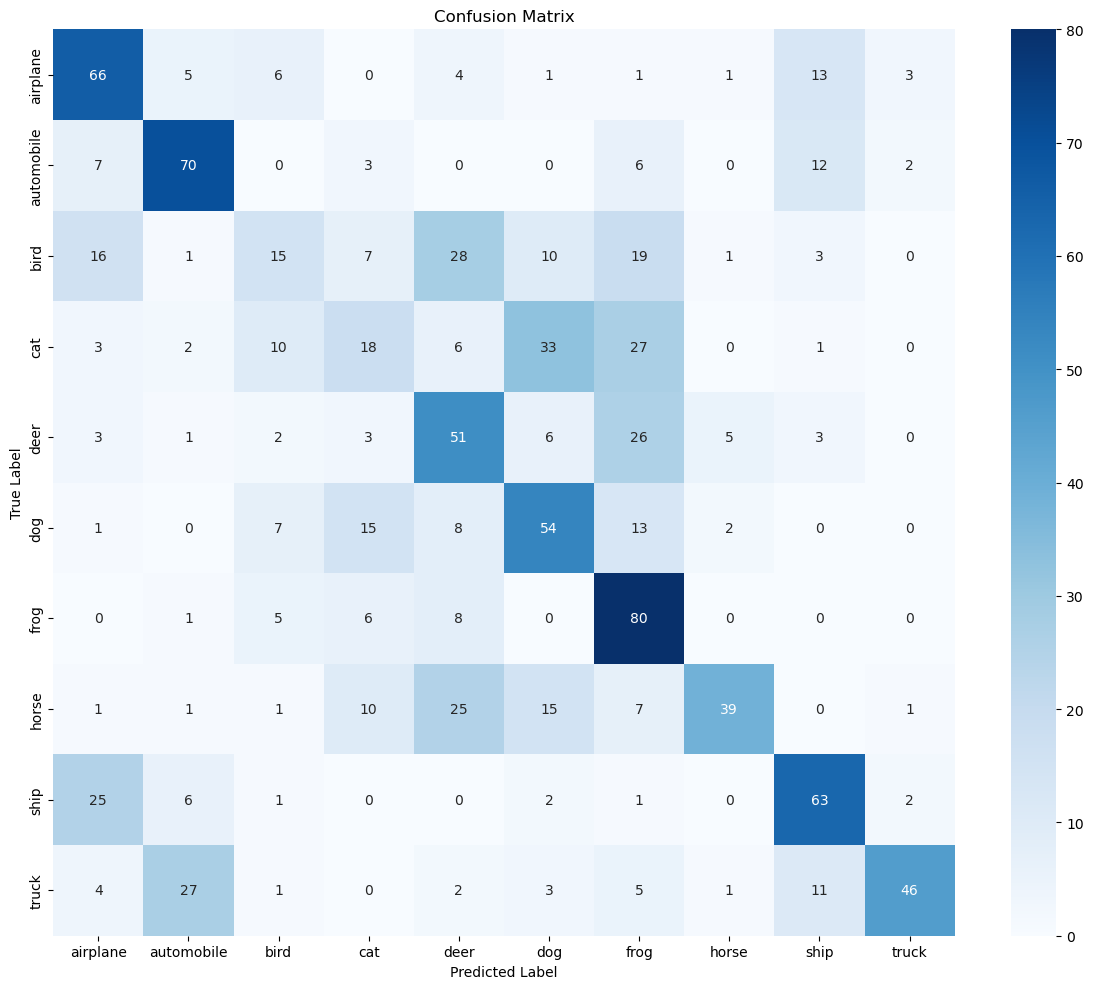


Confusion Matrix for VGG8


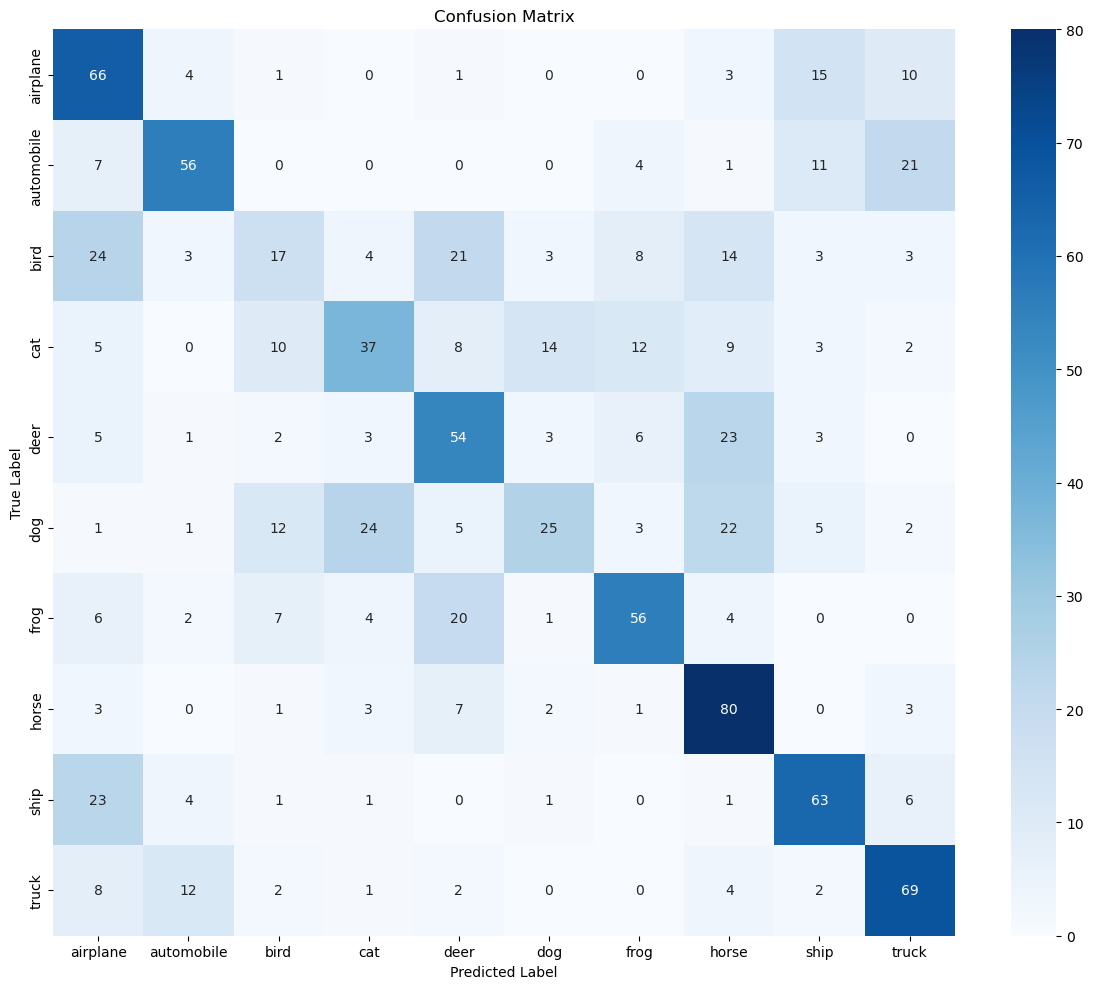


Confusion Matrix for VGG11_LargeKernel


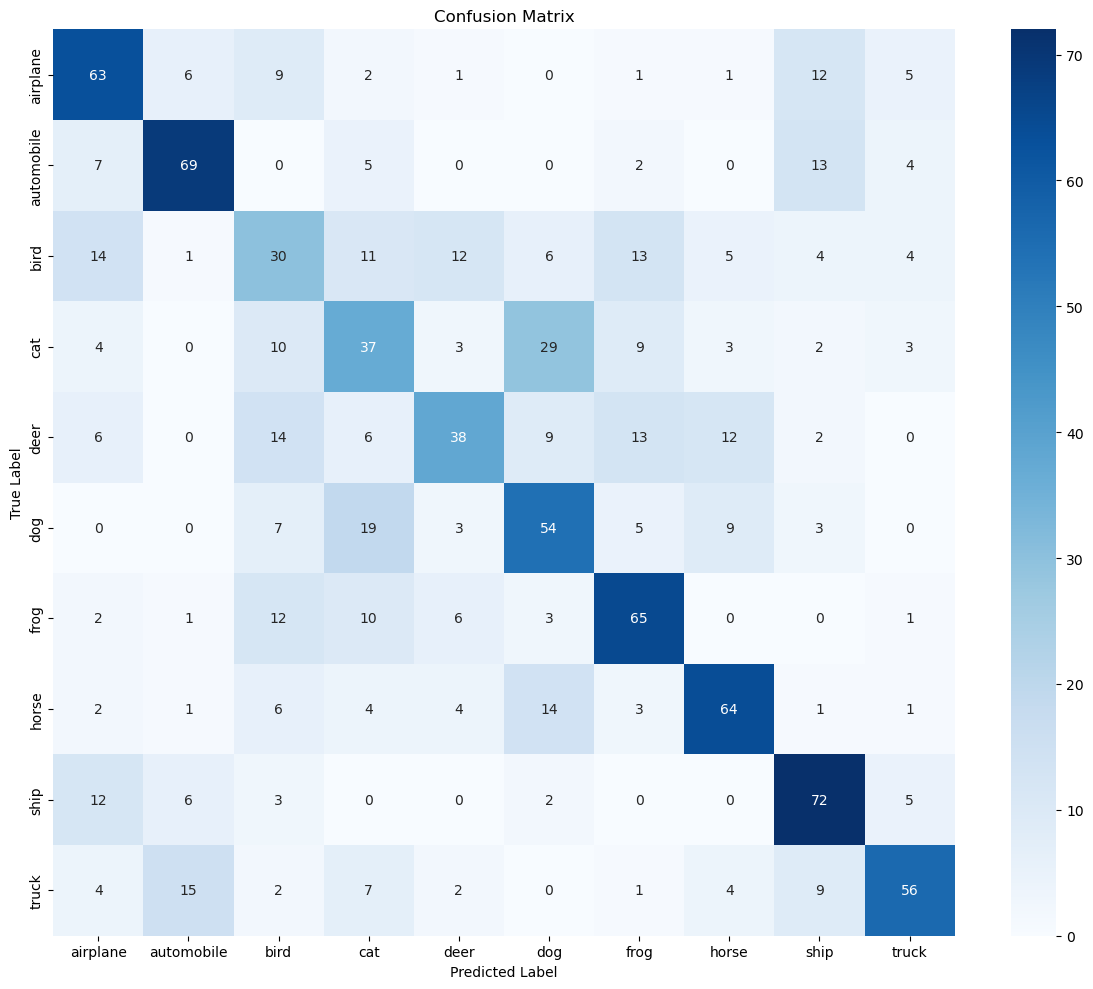


Performance Summary Table:
            Model Accuracy Precision Recall F1-Score
            VGG11   0.5020    0.5237 0.5020   0.4879
             VGG8   0.5230    0.5204 0.5230   0.5072
VGG11_LargeKernel   0.5480    0.5503 0.5480   0.5455


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using: ",device.type)


train_loader, test_loader = get_limited_data_loaders(batch_size=128)

# Train original VGG11
model_vgg11 = VGG11().to(device)
metrics_vgg11 = train_model(model_vgg11, train_loader, test_loader, epochs=10, device=device)

# Train VGG8 (reduced depth)
model_vgg8 = VGG8().to(device)
metrics_vgg8 = train_model(model_vgg8, train_loader, test_loader, epochs=10, device=device)

# Train VGG11 with larger kernels
model_vgg11_large = VGG11LargeKernel().to(device)
metrics_vgg11_large = train_model(model_vgg11_large, train_loader, test_loader, epochs=10, device=device)

# Usage example:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

#Dictionary with all model variants
models_dict = {
    'VGG11': model_vgg11,
    'VGG8': model_vgg8,
    'VGG11_LargeKernel': model_vgg11_large
}

#performance summary
summary_table = create_performance_summary(models_dict, test_loader, device, class_names)
print("\nPerformance Summary Table:")
print(summary_table.to_string(index=False))